In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/anti-uav-yolo-1024/valid/labels/01028.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/01484.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/00588.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/00286.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/00080.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/01279.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/00440.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/02557.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/01936.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/00733.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/00134.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/01466.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/00709.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/00372.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/01850.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/02017.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/02363.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/01

In [2]:
import os
import collections
import pandas as pd
import numpy as np
import functools
import matplotlib.pyplot as plt
import cv2
from sklearn import preprocessing
import xml.etree.ElementTree as ET

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

import torchvision
from torchvision.models.detection.ssd import SSDHead,det_utils
from torchvision.models.detection import ssd300_vgg16,SSD300_VGG16_Weights
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import SequentialSampler

import glob
import cv2
from PIL import Image

In [3]:
BASE_PATH = "/kaggle/input/anti-uav-yolo-1024/train"
TXT_PATH = glob.glob("/kaggle/input/anti-uav-yolo-1024/train/labels/*.txt")
IMG_PATH = glob.glob("/kaggle/input/anti-uav-yolo-1024/train/images/*.jpg")
IMG_PATH2 = glob.glob("/kaggle/input/anti-uav-yolo-1024/valid/images/*.jpg")

In [4]:
def convert_format(box, iwidth=300, iheight=300):
    x_center, y_center, width, height = box
    
    x_min = int((x_center - width / 2) * iwidth)
    y_min = int((y_center - height / 2) * iheight)
    x_max = int((x_center + width / 2) * iwidth)
    y_max = int((y_center + height / 2) * iheight)
    
    return [x_min, y_min, x_max, y_max]

In [5]:
import os
from PIL import Image

train_image = []
train_image_path = []
train_image_id = []
train_annotation = []

for img_path in IMG_PATH:
    # Extract image ID
    image_id = os.path.basename(img_path).split('.')[0]
   

    # Construct path for annotation file
    annotation_path = os.path.join("/kaggle/input/anti-uav-yolo-1024/train/labels/", image_id + ".txt")

    # Check if annotation file exists
    if os.path.exists(annotation_path):
        # Check if annotation file is not empty
        if os.path.getsize(annotation_path) > 0:
            Load_image = Image.open(img_path).convert('RGB')
            nmpy_img = Load_image.resize((300, 300))
            train_image.append(np.asarray(nmpy_img))
            train_image_path.append(img_path)
            train_image_id.append(image_id)

            # Read annotation file
            with open(annotation_path) as f:
                lines = f.readlines()
                tmp_lst = lines[0].split(' ')
                startX = float(tmp_lst[1])
                startY = float(tmp_lst[2])
                endX = float(tmp_lst[3])
                endY = float(tmp_lst[4])

                train_annotation.append(convert_format([startX, startY, endX, endY]))
        else:
            print(f"Annotation file is empty for image: {img_path}")
    else:
        print(f"Annotation file not found for image: {img_path}")

print("Images and annotations processed successfully.")

Annotation file is empty for image: /kaggle/input/anti-uav-yolo-1024/train/images/00639.jpg
Annotation file is empty for image: /kaggle/input/anti-uav-yolo-1024/train/images/00724.jpg
Annotation file is empty for image: /kaggle/input/anti-uav-yolo-1024/train/images/00579.jpg
Images and annotations processed successfully.


In [6]:
valid_image = []
valid_image_path = []
valid_image_id = []
valid_annotation = []

for img_path in IMG_PATH2:
    # Extract image ID
    image_id = os.path.basename(img_path).split('.')[0]
   

    # Construct path for annotation file
    annotation_path = os.path.join("/kaggle/input/anti-uav-yolo-1024/valid/labels/", image_id + ".txt")

    # Check if annotation file exists
    if os.path.exists(annotation_path):
        # Check if annotation file is not empty
        if os.path.getsize(annotation_path) > 0:
            Load_image = Image.open(img_path).convert('RGB')
            nmpy_img = Load_image.resize((300, 300))
            valid_image.append(np.asarray(nmpy_img))
            valid_image_path.append(img_path)
            valid_image_id.append(image_id)

            # Read annotation file
            with open(annotation_path) as f:
                lines = f.readlines()
                tmp_lst = lines[0].split(' ')
                startX = float(tmp_lst[1])
                startY = float(tmp_lst[2])
                endX = float(tmp_lst[3])
                endY = float(tmp_lst[4])

                valid_annotation.append(convert_format([startX, startY, endX, endY]))
        else:
            print(f"Annotation file is empty for image: {img_path}")
    else:
        print(f"Annotation file not found for image: {img_path}")

print("Images and annotations processed successfully.")

Images and annotations processed successfully.


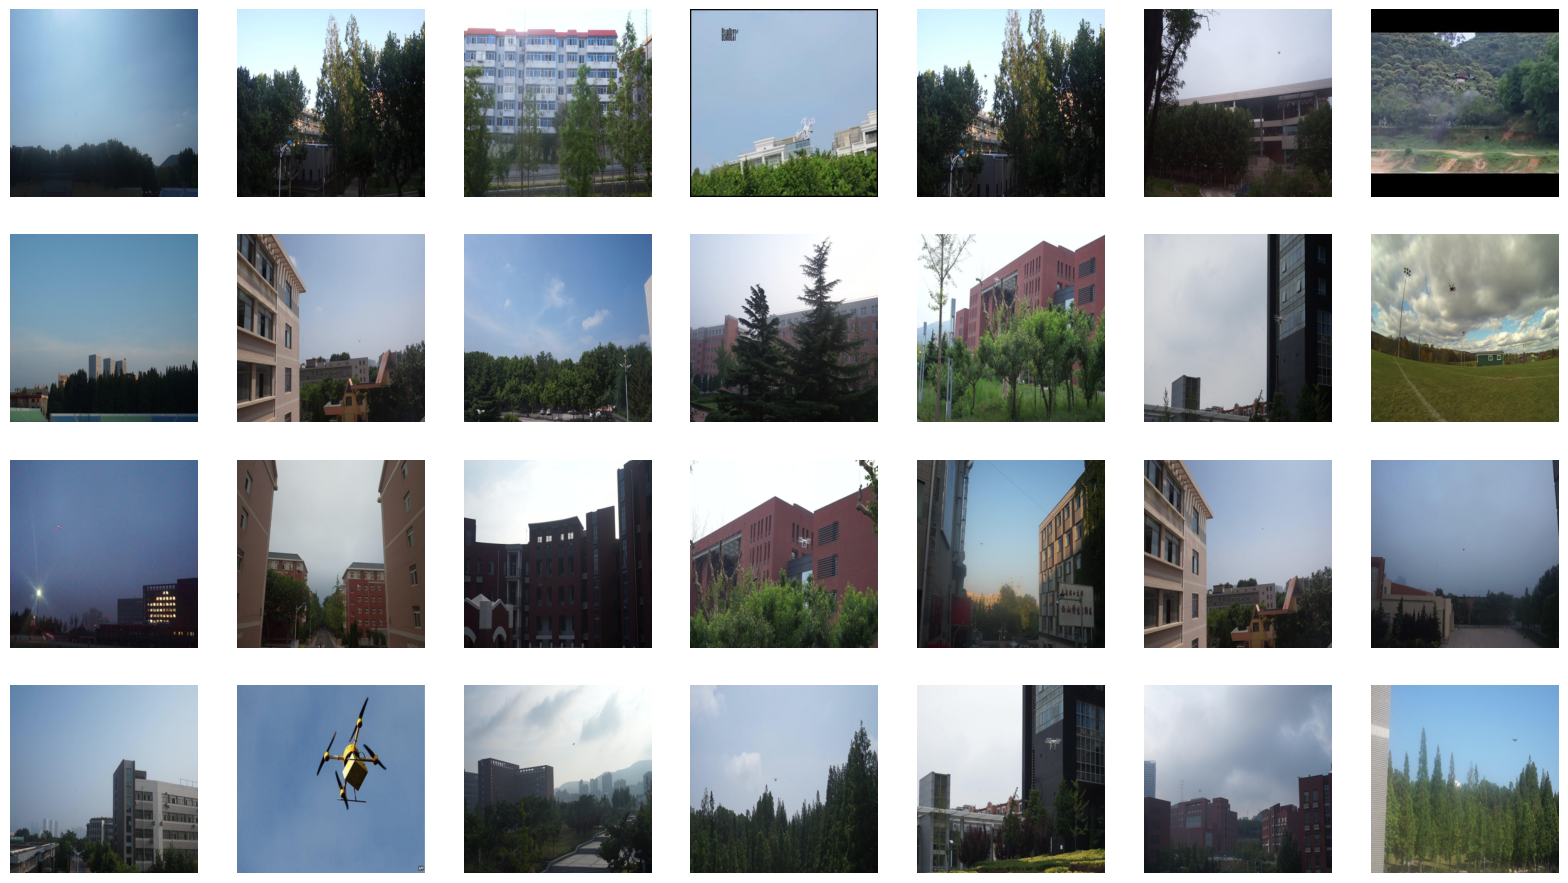

In [7]:
plt.figure(figsize=(20, 20))

for i in range(28):
    ax = plt.subplot(7, 7, i + 1)
    plt.imshow(train_image[i].astype("uint8"))
    plt.axis("off")

In [8]:
df = pd.DataFrame()
df['boxes'] = train_annotation
df['img_path'] = train_image_path
df['labels'] = 'drone'
df['img_id'] = train_image_id

df2 = pd.DataFrame()
df2['boxes'] = valid_annotation
df2['img_path'] = valid_image_path
df2['labels'] = 'drone'
df2['img_id'] = valid_image_id

In [9]:
import numpy as np
from sklearn import preprocessing

enc = preprocessing.LabelEncoder()
df['labels'] = enc.fit_transform(df['labels'])
df['labels'] = np.stack([df['labels'][i]+1 for i in range(len(df['labels']))])

df2['labels'] = enc.fit_transform(df2['labels'])
df2['labels'] = np.stack([df2['labels'][i]+1 for i in range(len(df2['labels']))])

In [10]:
import numpy as np

# Assuming df['boxes'] contains arrays/lists of coordinates
# Create separate columns for 'xmin', 'ymin', 'xmax', 'ymax'
df[['xmin', 'ymin', 'xmax', 'ymax']] = np.stack(df['boxes'].apply(lambda x: np.array(x)).values)

# Drop the 'boxes' column
df.drop(columns=['boxes'], inplace=True)
df['xmin'] = df['xmin'].astype(float)
df['ymin'] = df['ymin'].astype(float)
df['xmax'] = df['xmax'].astype(float)
df['ymax'] = df['ymax'].astype(float)

df2[['xmin', 'ymin', 'xmax', 'ymax']] = np.stack(df2['boxes'].apply(lambda x: np.array(x)).values)

# Drop the 'boxes' column
df2.drop(columns=['boxes'], inplace=True)
df2['xmin'] = df2['xmin'].astype(float)
df2['ymin'] = df2['ymin'].astype(float)
df2['xmax'] = df2['xmax'].astype(float)
df2['ymax'] = df2['ymax'].astype(float)

In [11]:
df_removed_damaged1 = df.drop(df[(df.ymin > df.ymax) | (df.xmin > df.xmax)].index)
df_removed_damaged1

mask = (df['ymin'] >= 300) | (df['ymax'] >= 300) | (df['xmin'] >= 300) | (df['xmax'] >= 300)
# Drop rows where the condition is True
df_removed_damaged = df_removed_damaged1.drop(df[mask].index)

df2_removed_damaged1 = df2.drop(df2[(df2.ymin >= df2.ymax) | (df2.xmin >= df2.xmax)].index)
df2_removed_damaged1

mask1 = (df2['ymin'] >= 300) | (df2['ymax'] >= 300) | (df2['xmin'] >= 300) | (df2['xmax'] >= 300)
# Drop rows where the condition is True
df2_removed_damaged = df2_removed_damaged1.drop(df2[mask1].index)

In [12]:
train_ds=df_removed_damaged
val_ds=df2_removed_damaged
val_ds
zero_mask = (train_ds['xmin'] <= 0) & (train_ds['ymin'] <= 0) & (train_ds['ymax'] <= 0) & (train_ds['xmax'] <= 0)
train_ds = train_ds[~zero_mask]
zero_mask2 = (val_ds['xmin'] <= 0) & (val_ds['ymin'] <= 0) & (val_ds['ymax'] <= 0) & (val_ds['xmax'] <= 0)
val_ds=val_ds[~zero_mask2]
print(len(train_ds))
print(len(val_ds))
print(zero_mask)
train_ds

5180
2592
0       False
1       False
2       False
3       False
4       False
        ...  
5192    False
5193    False
5194    False
5195    False
5196    False
Length: 5180, dtype: bool


img_path  labels img_id   xmin  \
0     /kaggle/input/anti-uav-yolo-1024/train/images/...       1  04168  165.0   
1     /kaggle/input/anti-uav-yolo-1024/train/images/...       1  02371   86.0   
2     /kaggle/input/anti-uav-yolo-1024/train/images/...       1  04377  137.0   
3     /kaggle/input/anti-uav-yolo-1024/train/images/...       1  00767  168.0   
4     /kaggle/input/anti-uav-yolo-1024/train/images/...       1  02360  105.0   
...                                                 ...     ...    ...    ...   
5192  /kaggle/input/anti-uav-yolo-1024/train/images/...       1  02956  143.0   
5193  /kaggle/input/anti-uav-yolo-1024/train/images/...       1  04731  147.0   
5194  /kaggle/input/anti-uav-yolo-1024/train/images/...       1  03358   46.0   
5195  /kaggle/input/anti-uav-yolo-1024/train/images/...       1  04801   18.0   
5196  /kaggle/input/anti-uav-yolo-1024/train/images/...       1  00117   50.0   

       ymin   xmax   ymax  
0     206.0  170.0  209.0  
1     105.0   93.0  112.0  
2     111.0  140.0  114.0  
3     174.0  199.0  210.0  
4     103.0  113.0  111.0  
...     ...    ...    ...  
5192  179.0  147.0  185.0  
5193  180.0  152.0  184.0  
5194  208.0   55.0  216.0  
5195  150.0   23.0  152.0  
5196  154.0  183.0  256.0  

[5180 rows x 7 columns]

In [13]:
transforms_train = A.Compose([
    A.HorizontalFlip(),
    A.OneOf([
        A.ColorJitter(hue=0.1),
        A.Equalize(by_channels=False),
        A.FancyPCA(),
        A.GaussNoise(),
        A.ImageCompression(),
        A.ISONoise(),
        A.RandomGamma(),
        A.RandomToneCurve(),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15),
        A.AdvancedBlur(p=0.1)
    ]),
    ToTensorV2()
    ],
    bbox_params=A.BboxParams(
        format='pascal_voc', label_fields=['labels'], min_area=21))

transforms_valid = ToTensorV2()

In [14]:
class VOC_2010(torch.utils.data.Dataset):
    def __init__(self, df, imdir, transforms):
        self.df = df
        self.imdir = imdir
        self.imnames = df['img_id'].unique()
        self.transforms = transforms
    
    def __getitem__(self, idx):
        imname = self.imnames[idx]
        image = cv2.imread(os.path.join(self.imdir+imname+'.jpg'), cv2.IMREAD_COLOR)
        image= cv2.resize(image, (300, 300))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #.astype(np.float32)
                        
        # Augmentation 
        mask = self.df['img_id'] == imname
        bboxes = np.array(self.df[mask][['xmin', 'ymin', 'xmax', 'ymax']])
        labels = np.array((self.df[mask]['labels']))
        transformed = self.transforms(image=image, bboxes=bboxes, labels=labels)
                        
        # Output for the model 
        image = transformed['image'] 
        bboxes = torch.as_tensor(transformed['bboxes'], dtype=torch.float16)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        if len(bboxes) == 0:
            target = {
                'boxes': torch.zeros((0, 4), dtype=torch.float32),
                'labels': torch.zeros(0, dtype=torch.int64)
                 }
        else:
                target = {'boxes': bboxes, 'labels': labels}
                        
        # Normalization
        image = image/255
               
        return image, target
    
    
    def __len__(self):
        return len(self.imnames)

In [15]:
img_dir1 = "/kaggle/input/anti-uav-yolo-1024/train/images/"
img_dir2 = "/kaggle/input/anti-uav-yolo-1024/valid/images/"
train_data = VOC_2010(train_ds, img_dir1, transforms_train)
valid_data = VOC_2010(val_ds, img_dir2, transforms_valid)

print('Training sample size', len(train_data))
print('Validation sample size', len(valid_data))

Training sample size 5180
Validation sample size 2592


In [16]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataloader = DataLoader(
    train_data, 
    batch_size=16,
    collate_fn=collate_fn
    )

valid_dataloader = DataLoader(
    valid_data, 
    batch_size=8,
    collate_fn=collate_fn
    )

# DataLoader for measuring metrics.  
metrics_dataloader = DataLoader(
    valid_data,
    batch_size=8,
    collate_fn=collate_fn
)

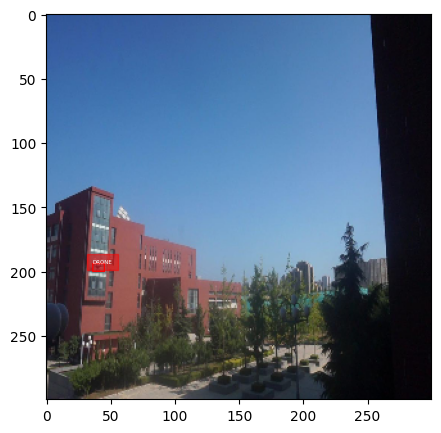

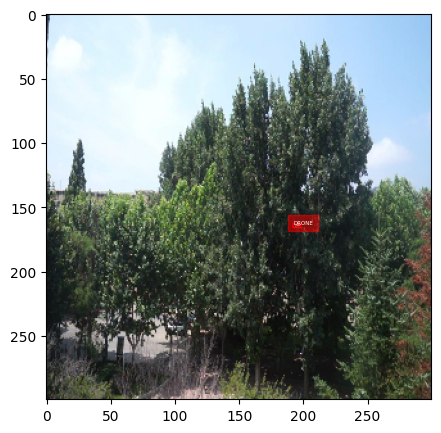

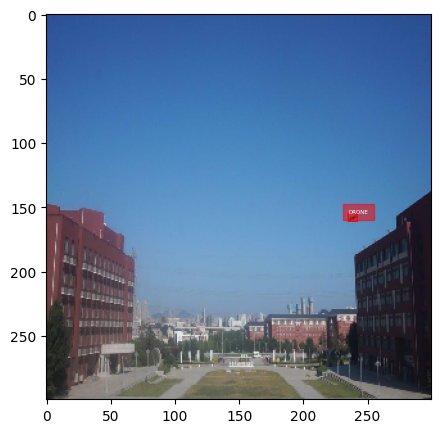

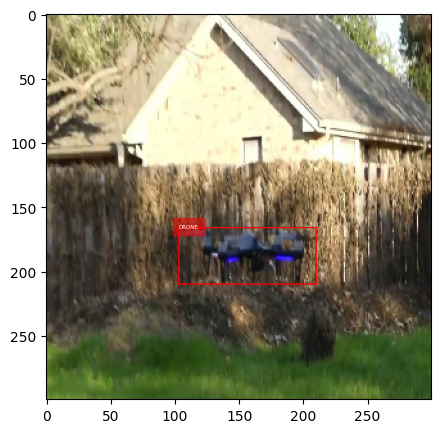

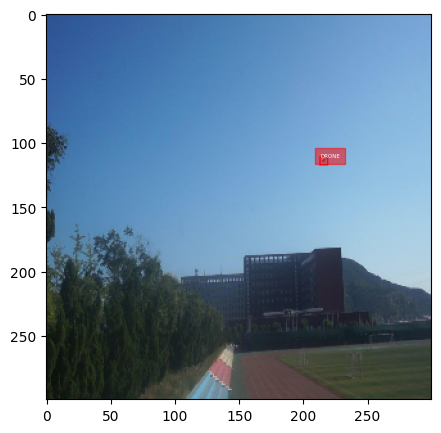

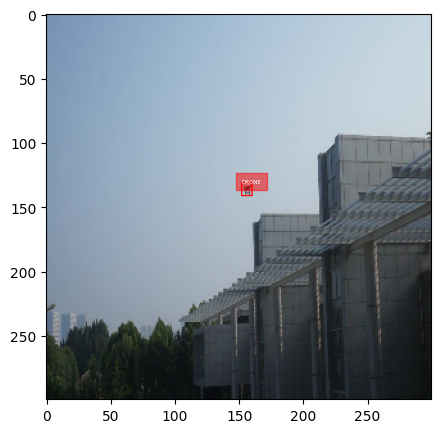

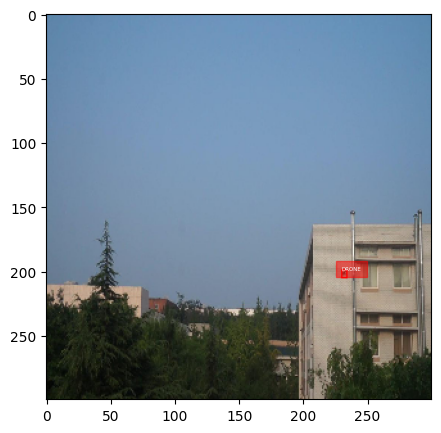

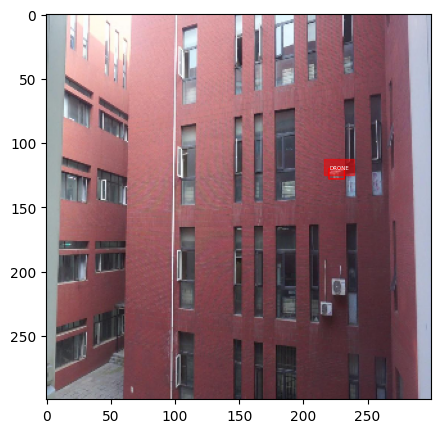

In [17]:
def image_convert(image):
    image = image.clone().cpu().numpy()
    image = image.transpose((1,2,0))
    image = (image * 255).astype(np.uint8)
    return image

def plot_img(data):
    img = next(iter(data))
    for num in range(8):
        image = image_convert(img[0][num])
        image = np.ascontiguousarray(image)
        bboxes = img[1][num]['boxes'].numpy()
        labels = img[1][num]['labels']
        fig, ax = plt.subplots(figsize=(5,5))
        
        for i, bbox in enumerate(bboxes):
            xmin, ymin, xmax, ymax = (int(bbox[0]), int(bbox[1]), int(bbox[2]), int(bbox[3]))
            cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 0, 0), thickness=1)
            text = ax.text(xmin, ymin, f'DRONE', fontsize=4, color='w')
            text.set_bbox(dict(facecolor='r', alpha=0.5, edgecolor='r'))
        plt.imshow(image);
    
plot_img(valid_dataloader)

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [19]:
model=ssd300_vgg16(weights=SSD300_VGG16_Weights.DEFAULT)
num_classes=2

in_channels=det_utils.retrieve_out_channels(model.backbone,(300,300))
num_anchors=model.anchor_generator.num_anchors_per_location()
model.head=SSDHead(in_channels=in_channels,num_anchors=num_anchors,
                   num_classes=num_classes)

model.to(device)

Downloading: "https://download.pytorch.org/models/ssd300_vgg16_coco-b556d3b4.pth" to /root/.cache/torch/hub/checkpoints/ssd300_vgg16_coco-b556d3b4.pth
100%|██████████| 136M/136M [00:00<00:00, 160MB/s]  


SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

In [20]:
import torch.optim as optim
import copy
from tqdm import tqdm

In [21]:
for params in model.backbone.features.parameters():
    params.requires_grad=False
    
parameters=[params for params in model.parameters() if params.requires_grad]

learning_rate=5e-4 
optimizer=optim.Adam(parameters,lr=learning_rate)
lr_scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, 
                                                  patience=7, threshold=0.0001)

In [22]:
def get_lr(optimizer):
    for params in optimizer.param_groups:
        return params["lr"]

In [24]:
num_anchors

[4, 6, 6, 6, 4, 4]

In [25]:
epochs=20
loss_history={"training_loss":[],
              "validation_loss":[]}

train_len= len(train_data)
val_len=len(valid_data)

best_validation_loss=np.inf
best_weights=copy.deepcopy(model.state_dict())

for epoch in range(epochs):
    
    training_loss=0.0
    validation_loss=0.0
    
    current_lr=get_lr(optimizer)
    
    #During training, the model expects both the input tensors, as well as a targets 
    model.train()
    #for imgs,targets in train_dataloader:
    for i, (imgs, targets) in tqdm(enumerate(train_dataloader)):
        imgs=[img.to(device) for img in imgs]
        targets=[{k:v.to(device) for (k,v) in d.items()} for d in targets]
        #targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
        #targets = [{k: torch.as_tensor(v).detach().to(device) for k, v in t.items()} for t in targets]
        
        loss_dict=model(imgs,targets)
        losses=sum(loss for loss in loss_dict.values())
        training_loss+=losses.item()
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
    with torch.no_grad():
        #for imgs,targets in valid_dataloader:
        for i, (imgs, targets) in tqdm(enumerate(valid_dataloader)):
            imgs=[img.to(device) for img in imgs]
            targets=[{k:v.to(device) for (k,v) in d.items()} for d in targets]
            #targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
            #targets = [{k: torch.as_tensor(v).detach().to(device) for k, v in t.items()} for t in targets]
           
            loss_dict=model(imgs,targets)
            losses=sum(loss for loss in loss_dict.values())
            validation_loss+=losses.item()
            
    lr_scheduler.step(validation_loss)
    if current_lr!=get_lr(optimizer):
        print("Loading best Model weights")
        model.load_state_dict(best_weights)
    
    if validation_loss<best_validation_loss:
        best_validation_loss=validation_loss
        best_weights=copy.deepcopy(model.state_dict())
        print("Updating Best Model weights")
        
    
    loss_history["training_loss"].append(training_loss/train_len)
    loss_history["validation_loss"].append(validation_loss/val_len)
            
    print(f"\n{epoch+1}/{epochs}")
    print(f"Training Loss: {training_loss/train_len}")
    print(f"Validation_loss: {validation_loss/val_len}")
    print("\n"+"*"*50)


324it [02:13,  2.43it/s]
324it [01:02,  5.22it/s]


Updating Best Model weights

1/20
Training Loss: 0.27919384535675346
Validation_loss: 0.5834636747101207

**************************************************


324it [02:13,  2.43it/s]
324it [01:03,  5.10it/s]


Updating Best Model weights

2/20
Training Loss: 0.22998911275826825
Validation_loss: 0.5376774738600225

**************************************************


324it [02:15,  2.40it/s]
324it [01:01,  5.25it/s]


Updating Best Model weights

3/20
Training Loss: 0.21306469472678932
Validation_loss: 0.5128821583441746

**************************************************


324it [02:14,  2.41it/s]
324it [01:04,  5.05it/s]


Updating Best Model weights

4/20
Training Loss: 0.20334762942376744
Validation_loss: 0.4997156974342134

**************************************************


324it [02:16,  2.37it/s]
324it [01:02,  5.14it/s]


Updating Best Model weights

5/20
Training Loss: 0.19480858912339083
Validation_loss: 0.49460089574625465

**************************************************


324it [02:18,  2.34it/s]
324it [01:03,  5.10it/s]


Updating Best Model weights

6/20
Training Loss: 0.18751574805344393
Validation_loss: 0.48769068166061685

**************************************************


324it [02:14,  2.41it/s]
324it [01:02,  5.22it/s]


Updating Best Model weights

7/20
Training Loss: 0.18405323272506244
Validation_loss: 0.4840631823480865

**************************************************


324it [02:16,  2.38it/s]
324it [01:03,  5.13it/s]


Updating Best Model weights

8/20
Training Loss: 0.1779511742380135
Validation_loss: 0.483624798004274

**************************************************


324it [02:14,  2.41it/s]
324it [01:03,  5.13it/s]


Updating Best Model weights

9/20
Training Loss: 0.17439937833193186
Validation_loss: 0.4828720665824266

**************************************************


324it [02:14,  2.40it/s]
324it [01:02,  5.18it/s]



10/20
Training Loss: 0.17294771634473763
Validation_loss: 0.4832960457345586

**************************************************


324it [02:15,  2.39it/s]
324it [01:02,  5.22it/s]


Updating Best Model weights

11/20
Training Loss: 0.16636840358203903
Validation_loss: 0.4779917707229838

**************************************************


324it [02:14,  2.41it/s]
324it [01:02,  5.16it/s]



12/20
Training Loss: 0.16148670246702362
Validation_loss: 0.48016972481100645

**************************************************


324it [02:15,  2.40it/s]
324it [01:02,  5.16it/s]



13/20
Training Loss: 0.16030632326501676
Validation_loss: 0.4817102304027404

**************************************************


324it [02:17,  2.36it/s]
324it [01:03,  5.12it/s]



14/20
Training Loss: 0.15774016674881275
Validation_loss: 0.47908225977494395

**************************************************


324it [02:18,  2.35it/s]
324it [01:02,  5.17it/s]



15/20
Training Loss: 0.15587529298421499
Validation_loss: 0.4808361356916987

**************************************************


324it [02:14,  2.41it/s]
324it [01:02,  5.17it/s]



16/20
Training Loss: 0.1539664198763122
Validation_loss: 0.47840981700538115

**************************************************


324it [02:16,  2.37it/s]
324it [01:04,  5.04it/s]



17/20
Training Loss: 0.15061150911231758
Validation_loss: 0.48799743972442766

**************************************************


324it [02:16,  2.37it/s]
324it [01:02,  5.15it/s]



18/20
Training Loss: 0.14908577645607438
Validation_loss: 0.4795445587348055

**************************************************


324it [02:15,  2.39it/s]
324it [01:03,  5.13it/s]


Loading best Model weights

19/20
Training Loss: 0.14671836895832224
Validation_loss: 0.49009048340865125

**************************************************


324it [02:15,  2.40it/s]
324it [01:02,  5.16it/s]

Updating Best Model weights

20/20
Training Loss: 0.15710208397574407
Validation_loss: 0.46849949947661823

**************************************************


In [26]:
!pip install pycocotools
! pip install -U ffmpeg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 7.6 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6080 sha256=d8dea8c79ace501923e3f905bf8e0af4dd7aad966e807cc93b049b3d857b94c8
  Stored in directory: /root/.cache/pip/wheels/8e/7a/69/cd6aeb83b126a7f04cbe7c9d929028dc52a6e7d525ff56003a
Successfully built ffmpeg


In [27]:
from torchmetrics.detection import MeanAveragePrecision
metric=MeanAveragePrecision(box_format='xyxy',class_metrics=True)
metric.to(device)

MeanAveragePrecision()

In [28]:
MeanAveragePrecision()
threshold=0.25
iou_threshold=0.75
def preprocess_bbox(prediction):
    
    """Non-max suppression is the final step of these object detection algorithms and is 
       used to select the most appropriate bounding box for the object.
       The NMS takes two things into account
        -The objectiveness score is given by the model
        -The overlap or IOU of the bounding boxes"""
    
    processed_bbox={}
    
    boxes=prediction["boxes"][prediction["scores"]>=threshold]
    scores=prediction["scores"][prediction["scores"]>=threshold]
    labels=prediction["labels"][prediction["scores"]>=threshold]
    nms=torchvision.ops.nms(boxes,scores,iou_threshold=iou_threshold)
            
    processed_bbox["boxes"]=boxes[nms]
    processed_bbox["scores"]=scores[nms]
    processed_bbox["labels"]=labels[nms]
    
    return processed_bbox

In [29]:
model.eval()
with torch.no_grad():
    """for imgs,targets in valid_data_loader:
        imgs=[img.to(device) for img in imgs]
        targets=[{k:v.to(device) for (k,v) in d.items()} for d in targets]
        #targets = [{k: torch.as_tensor(v).detach().to(device) for k, v in t.items()} for t in targets]"""
    for i, (imgs, targets) in tqdm(enumerate(valid_dataloader)):
            imgs = list(image.to(device) for image in imgs)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            predictions=model(imgs)
        
            results=[]
            for prediction in predictions:
                results.append(preprocess_bbox(prediction))
                #results.append(prediction)
            metric.update(results,targets)
results=metric.compute()

324it [01:04,  5.00it/s]


In [30]:
ssd_mean_ap=results["map"].item()
ssd_mean_ap_50=results["map_50"].item()
ssd_mean_ap_75=results["map_75"].item()

print(f"Mean Average Precision[0.5:0.95:0.05] : {ssd_mean_ap:.4f}")
print(f"Mean Average Precision @ 0.5          : {ssd_mean_ap_50:.4f}")
print(f"Mean Average Precision @ 0.75         : {ssd_mean_ap_75:.4f}")

Mean Average Precision[0.5:0.95:0.05] : 0.1880
Mean Average Precision @ 0.5          : 0.3903
Mean Average Precision @ 0.75         : 0.1576
